# Image Processing and Computer Vision Project

In [6]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
from sklearn.cluster import DBSCAN

## Prove A

In [7]:
img_scene = cv2.imread('scenes/e2.png', cv2.IMREAD_COLOR) # sceneImage BGR
img_prod = cv2.imread('models/0.jpg', cv2.IMREAD_COLOR) # prodImage BGR
#img_scene_rgb = cv2.cvtColor(img_scene, cv2.COLOR_BGR2RGB)

In [8]:
img_prod_gr = cv2.cvtColor(img_prod, cv2.COLOR_BGR2GRAY)

In [9]:
img_prod_eq = cv2.equalizeHist(img_prod_gr)
sharpen_kernel = np.array([
            [0,-1,0],
            [-1,5,-1],
            [0,-1,0]])

img_prod_pre = cv2.filter2D(img_prod_eq,-1,sharpen_kernel)
img_prod_pre = np.abs(img_prod_pre)

In [10]:
# Detecting keypoints and computing the descriptors for each keypoints in the product image
sift = cv2.xfeatures2d.SIFT_create()
kp_p, des_p = sift.detectAndCompute(img_prod_eq, None)

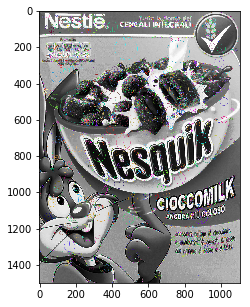

In [11]:
plt.figure(figsize=(5,5))
img_visualization = cv2.drawKeypoints(img_prod_eq,kp_p,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_visualization, cmap='gray', vmin=0, vmax=255)
plt.show()

In [12]:
img_scene_gr = cv2.cvtColor(img_scene, cv2.COLOR_BGR2GRAY)

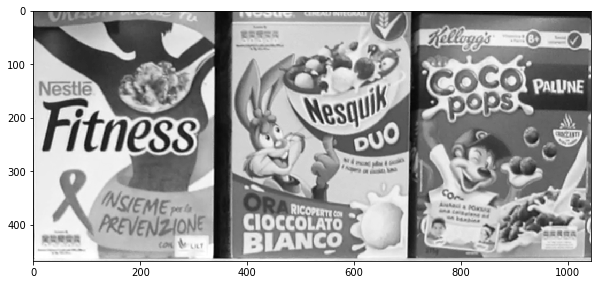

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(img_scene_gr, cmap='gray')

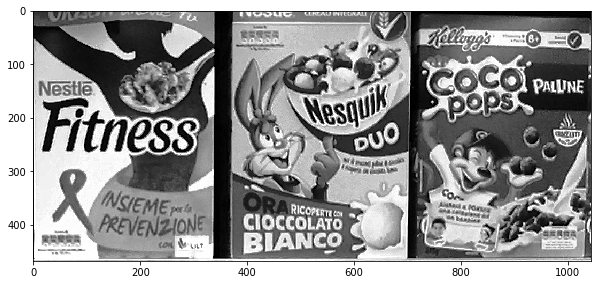

In [14]:
img_scene_eq = cv2.equalizeHist(img_scene_gr)
sharpen_kernel = np.array([
            [0,-1,0],
            [-1,5,-1],
            [0,-1,0]])
gy_kernel = np.array([
            [1,2,1],
            [0,0,0],
            [-1,-2,-1]])
img_scene_pre = cv2.filter2D(img_scene_eq,-1,sharpen_kernel)
img_scene_pre = np.abs(img_scene_pre)
plt.figure(figsize=(10,10))
plt.imshow(img_scene_pre, cmap='gray', vmin=0, vmax=255)
plt.show()

In [15]:
# Detecting keypoints and computing the descriptors for each keypoints in the scene image
sift = cv2.xfeatures2d.SIFT_create()
kp_s, des_s = sift.detectAndCompute(img_scene_pre, None)

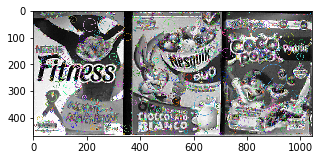

In [16]:
plt.figure(figsize=(5,5))
img_visualization = cv2.drawKeypoints(img_scene_pre,kp_s,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_visualization, cmap='gray', vmin=0, vmax=255)
plt.show()

In [17]:
# Initializing the matching algorithm
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching the descriptors
matches = flann.knnMatch(des_p,des_s,k=2)

# Keeping only good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

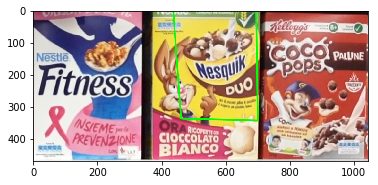

In [18]:
# If we have at least 10 matches we find the box of the object
MIN_MATCH_COUNT = 80
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp_p[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_s[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    # Calculating homography based on correspondences
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0)

    # Matches mask for visualization of only matches used by RANSAC
    matchesMask = mask.ravel().tolist()

    # Apply homography to project corners of the query image into the image
    h,w = img_prod_gr.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    
    # Calculate the bounding box
    x, y, w, h = cv2.boundingRect(dst)
    
    # Drawing bounding box
    final_img = img_scene.copy()
    final_img = cv2.polylines(final_img,np.int32([dst]),True,(0,255,0), 3, cv2.LINE_AA)
    final_img_rgb = cv2.cvtColor(final_img,cv2.COLOR_BGR2RGB)
    plt.imshow(final_img_rgb)
    plt.show()

else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

In [25]:
for pt in dst:
    if pt[0][0] < 0 or pt[0][1] < 0:
        print('True')


True
True


In [19]:
len(good)

205

In [175]:
cv2.isContourConvex(dst)

True

In [173]:
bounds_area = cv2.contourArea(dst)
rect_area = w * h
rectangularity = bounds_area / rect_area

In [174]:
rectangularity

0.9219323450075474

In [1]:
l = [[],[1,2],[3],[],[4]]

In [4]:
l = [x for x in l if x!=[]]

In [5]:
l

[[1, 2], [3], [4]]

In [31]:
dst

array([[[ 14.823437 ,   4.4990745]],

       [[-50.332123 , 566.0835   ]],

       [[361.46414  , 568.67957  ]],

       [[312.339    ,   9.221374 ]]], dtype=float32)

In [110]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img_prod_gr,kp_p,img_scene_gr,kp_s,good,None,**draw_params)
plt.imshow(img3, 'gray')
plt.show()

error: OpenCV(3.4.2) /io/opencv/modules/features2d/src/draw.cpp:198: error: (-201:Incorrect size of input array) matchesMask must have the same size as matches1to2 in function 'drawMatches'


## Prove B

In [86]:
img_scene = cv2.imread('scenes/m5.png', cv2.IMREAD_COLOR) # sceneImage BGR
img_prod = cv2.imread('models/25.jpg', cv2.IMREAD_COLOR) # prodImage BGR
img_prod_gr = cv2.cvtColor(img_prod, cv2.COLOR_BGR2GRAY)
img_scene_gr = cv2.cvtColor(img_scene, cv2.COLOR_BGR2GRAY)

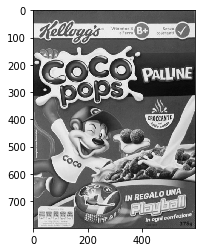

In [87]:
#plt.figure(figsize=(10,10))
plt.imshow(img_prod_gr, cmap='gray')

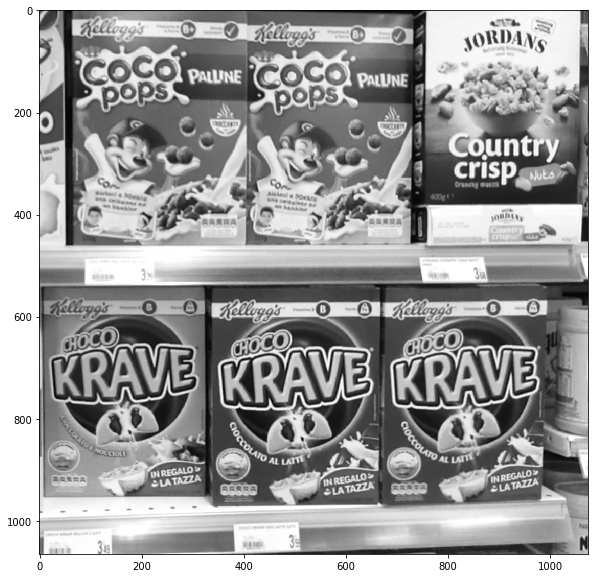

In [88]:
plt.figure(figsize=(10,10))
plt.imshow(img_scene_gr, cmap='gray')

In [89]:
# Detecting keypoints and computing the descriptors for each keypoints in the product image
sift = cv2.xfeatures2d.SIFT_create()
kp_p, des_p = sift.detectAndCompute(img_prod_gr, None)

# Compute the barycenter for the GHT
x = np.mean([kp.pt[0] for kp in kp_p])
y = np.mean([kp.pt[1] for kp in kp_p])
barycen_p = [x,y]

In [90]:
barycen_p

[321.8635759276036, 501.2949750660364]

In [91]:
img_scene_eq = cv2.equalizeHist(img_scene_gr)
sharpen_kernel = np.array([
            [0,-1,0],
            [-1,5,-1],
            [0,-1,0]])
img_scene_pre = cv2.filter2D(img_scene_eq,-1,sharpen_kernel)
img_scene_pre = np.abs(img_scene_pre)

# Detecting keypoints and computing the descriptors for each keypoints in the scene image
sift = cv2.xfeatures2d.SIFT_create()
kp_s, des_s = sift.detectAndCompute(img_scene_pre, None)

In [92]:
# Initializing the matching algorithm
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching the descriptors
matches = flann.knnMatch(des_p,des_s,k=2)

# Keeping only good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [93]:
len(good)

225

In [94]:
aa_quant_fact = 5
aa_matrix = np.zeros((img_scene_gr.shape[0]//aa_quant_fact, img_scene_gr.shape[1]//aa_quant_fact))


In [95]:
aa_matrix.shape

(213, 214)

In [96]:
# Online phase of the GHT algorithm
aa_quant_fact = 5
aa_matrix = np.zeros((img_scene_gr.shape[0]//aa_quant_fact, img_scene_gr.shape[1]//aa_quant_fact))
dict_matches = {}

for m in good:
    # Retrieve only good matches
    kp_p_good = kp_p[m.queryIdx]
    kp_s_good = kp_s[m.trainIdx]

    # Compute the vector that connects each keypoint to the barycenter
    vec = np.subtract(barycen_p, kp_p_good.pt)

    # Scale the vector 
    vec_scaled = np.multiply(vec, kp_s_good.size/kp_p_good.size)

    # Rotate the vector
    rot_angle = math.radians(kp_s_good.angle - kp_p_good.angle)
    rot_matrix = np.array(((np.cos(rot_angle), -np.sin(rot_angle)),(np.sin(rot_angle), np.cos(rot_angle))))
    vec_scaled_rot = rot_matrix.dot(vec_scaled)
    
    # Calculate barycenter
    bar_x = int(round(kp_s_good.pt[0] + vec_scaled_rot[0])//aa_quant_fact)
    bar_y = int(round(kp_s_good.pt[1] + vec_scaled_rot[1])//aa_quant_fact)
    
    bar = (bar_x, bar_y)
    if bar in dict_matches.keys():
        dict_matches[bar].append(m)
    else:
        dict_matches[bar] = [m]
                
    
    # Cast a vote
    if 0 <= bar[0] < aa_matrix.shape[1] and 0 <= bar[1] < aa_matrix.shape[0]:
        aa_matrix[bar[1], bar[0]] += 1

In [186]:
aaMatches

NameError: name 'aaMatches' is not defined

In [13]:
aa_matrix.shape

(123, 278)

In [15]:
np.max(aa_matrix)

3.0

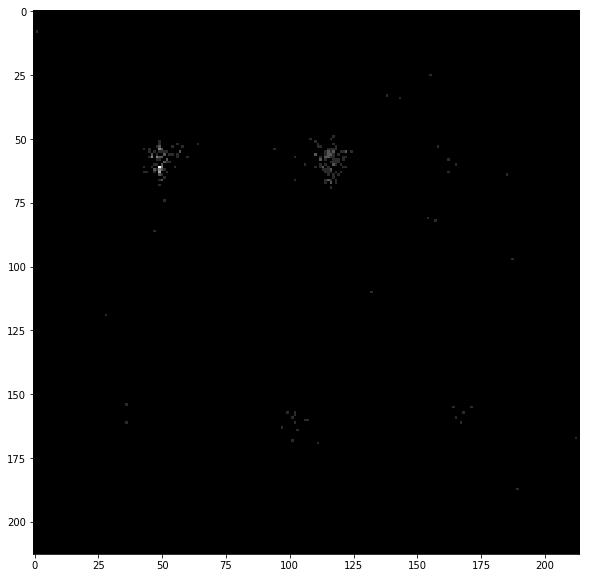

In [97]:
plt.figure(figsize=(10,10))
plt.imshow(aa_matrix, cmap='gray')

In [422]:
non_null = aa_matrix>0

In [98]:
non_null=np.concatenate((np.nonzero(aa_matrix)[1].reshape((-1,1)), np.nonzero(aa_matrix)[0].reshape((-1,1))), axis=1)

In [29]:
non_null[1]

array([96, 48])

In [42]:
np.array(non_null_2)

array([[132,  41],
       [ 96,  48],
       [ 97,  50],
       [ 98,  50],
       [ 99,  50],
       [ 99,  50],
       [100,  50],
       [234,  50],
       [235,  50],
       [ 99,  51],
       [102,  51],
       [ 86,  52],
       [ 98,  52],
       [ 99,  52],
       [ 99,  52],
       [ 99,  52],
       [100,  52],
       [101,  52],
       [102,  52],
       [102,  52],
       [103,  52],
       [107,  52],
       [165,  52],
       [233,  52],
       [233,  52],
       [234,  52],
       [ 99,  53],
       [163,  53],
       [163,  53],
       [166,  53],
       [167,  53],
       [168,  53],
       [230,  53],
       [231,  53],
       [233,  53],
       [233,  53],
       [234,  53],
       [166,  54],
       [167,  54],
       [167,  54],
       [168,  54],
       [230,  54],
       [240,  54],
       [167,  55],
       [ 97,  56],
       [174,  56],
       [166,  58],
       [236,  58],
       [ 99,  59],
       [ 96,  60],
       [ 98,  61],
       [ 99,  61],
       [157,

In [99]:
non_null_2 = []
for i in range(non_null.shape[0]):
    for j in range(int(aa_matrix[non_null[i,1],non_null[i,0]])):
        non_null_2.append(non_null[i].tolist())
non_null_2 = np.array(non_null_2)

In [100]:
non_null.shape, non_null_2.shape

((178, 2), (224, 2))

In [103]:
from sklearn.cluster import DBSCAN
y = DBSCAN(eps=10, min_samples=20).fit_predict(non_null_2)

In [104]:
y

array([-1, -1, -1, -1,  0,  0,  0,  1,  0,  1,  1,  1,  0,  0,  1,  1,  1,
        1,  1,  0,  0,  0, -1,  1,  1,  1,  1,  1,  1,  1, -1,  0,  0,  0,
        0,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  0,  0,  0,  0,
        0,  0,  0, -1,  1,  1,  1,  1,  0,  0,  0,  0,  1,  1,  1,  1,  0,
        0,  0,  0,  0,  0,  0, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,
        0,  0, -1,  1,  1,  1,  0,  0,  0, -1,  1,  0,  1,  1,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1])

In [105]:
cluster_labels_all = np.unique(y)
cluster_labels = cluster_labels_all[cluster_labels_all != -1]
n_clusters = len(cluster_labels)

In [106]:
cluster_labels_all = np.unique(y)
cluster_labels = cluster_labels_all[cluster_labels_all != -1]
n_clusters = len(cluster_labels)
cl = []
for i in cluster_labels:
    cl.append(non_null_2[y==i].tolist())

In [107]:
cl

[[[117, 49],
  [108, 50],
  [116, 50],
  [110, 51],
  [111, 52],
  [117, 52],
  [111, 53],
  [112, 53],
  [118, 53],
  [115, 54],
  [116, 54],
  [117, 54],
  [118, 54],
  [114, 55],
  [115, 55],
  [115, 55],
  [116, 55],
  [117, 55],
  [117, 55],
  [120, 55],
  [121, 55],
  [122, 55],
  [122, 55],
  [124, 55],
  [110, 56],
  [110, 56],
  [114, 56],
  [115, 56],
  [115, 56],
  [116, 56],
  [116, 56],
  [117, 56],
  [119, 56],
  [102, 57],
  [112, 57],
  [114, 57],
  [114, 57],
  [115, 57],
  [115, 57],
  [116, 57],
  [117, 57],
  [121, 57],
  [122, 57],
  [112, 58],
  [112, 58],
  [114, 58],
  [117, 58],
  [118, 58],
  [119, 58],
  [121, 58],
  [116, 59],
  [117, 59],
  [118, 59],
  [119, 59],
  [106, 60],
  [112, 60],
  [114, 60],
  [117, 60],
  [117, 60],
  [118, 60],
  [120, 60],
  [110, 61],
  [112, 61],
  [113, 61],
  [113, 61],
  [115, 61],
  [121, 61],
  [122, 61],
  [113, 62],
  [114, 62],
  [115, 62],
  [116, 62],
  [116, 62],
  [114, 63],
  [115, 63],
  [116, 63],
  [118, 63],

In [108]:
for instance in cl:
    instanceMatches = []
    for pt in instance:
        instanceMatches += dict_matches[tuple(pt)]
    print(len(instanceMatches))
    if len(instanceMatches) > 30:
        prova = instanceMatches

121
195


In [67]:
maxDist = 15
clusters = []

for y in range(aa_matrix.shape[0]):
    for x in range(aa_matrix.shape[1]):
        if aa_matrix[y,x] > 0:
            poss_cl = []
            for cl_id, cl in enumerate(clusters):
                for pt in cl:
                    dist = math.sqrt((x-pt[0])**2 + (y-pt[1])**2)
                    if dist <= maxDist:
                        poss_cl.append(cl_id)
                        break

            if len(poss_cl) == 0:
                # Create a new cluster
                clusters.append([(x,y)]) 
            else:
                # Combine clusters
                for cl in poss_cl[1:][::-1]:
                    clusters[poss_cl[0]] += clusters[cl]
                    del clusters[cl]

                clusters[poss_cl[0]].append((x,y))


In [202]:
len(clusters)

2

In [203]:
clusters

[[(171, 42),
  (172, 45),
  (171, 47),
  (172, 47),
  (175, 47),
  (165, 48),
  (169, 48),
  (170, 48),
  (171, 48),
  (173, 48),
  (173, 50),
  (175, 50),
  (167, 52),
  (174, 53),
  (173, 56)],
 [(50, 48)]]

In [205]:
for instance in clusters:
    instanceMatches = []
    for pt in instance:
        instanceMatches += dict_matches[pt]
    print(len(instanceMatches))
    if len(instanceMatches) > 10:
        prova = instanceMatches

15
1


In [206]:
prova

[<DMatch 0x7fc6e189fa10>,
 <DMatch 0x7fc6e1891970>,
 <DMatch 0x7fc6e189fab0>,
 <DMatch 0x7fc6e18a3e30>,
 <DMatch 0x7fc6e18a39b0>,
 <DMatch 0x7fc6e1891b30>,
 <DMatch 0x7fc6e189fad0>,
 <DMatch 0x7fc6e189f410>,
 <DMatch 0x7fc6e1891e90>,
 <DMatch 0x7fc6e18a3890>,
 <DMatch 0x7fc6e18a32d0>,
 <DMatch 0x7fc6e1891030>,
 <DMatch 0x7fc6e189fcf0>,
 <DMatch 0x7fc6e18a3690>,
 <DMatch 0x7fc6e18a3190>]

In [198]:
len(instanceMatches)

15

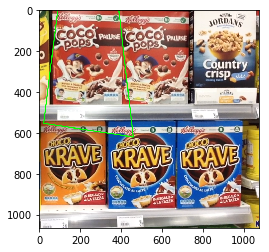

In [109]:
src_pts = np.float32([ kp_p[m.queryIdx].pt for m in prova ]).reshape(-1,1,2)
dst_pts = np.float32([ kp_s[m.trainIdx].pt for m in prova ]).reshape(-1,1,2)

# Calculating homography based on correspondences
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Matches mask for visualization of only matches used by RANSAC
matchesMask = mask.ravel().tolist()

# Apply homography to project corners of the query image into the image
h,w = img_prod_gr.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)

# Calculate the bounding box
x, y, w, h = cv2.boundingRect(dst)

# Drawing bounding box
final_img = img_scene.copy()
final_img = cv2.polylines(final_img,np.int32([dst]),True,(0,255,0), 3, cv2.LINE_AA)
final_img_rgb = cv2.cvtColor(final_img,cv2.COLOR_BGR2RGB)
plt.imshow(final_img_rgb)
plt.show()

In [113]:
kp_p_g = [ kp_p[m.queryIdx] for m in prova ]
kp_s_g = [ kp_s[m.trainIdx] for m in prova ]

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img_prod_gr,kp_p_g,img_scene_gr,kp_s_g,good,None,**draw_params)
plt.imshow(img3, 'gray')
plt.show()

error: OpenCV(3.4.2) /io/opencv/modules/features2d/src/draw.cpp:198: error: (-201:Incorrect size of input array) matchesMask must have the same size as matches1to2 in function 'drawMatches'


## Prove C

In [119]:
img_scene = cv2.imread('scenes/h5.jpg', cv2.IMREAD_COLOR) # sceneImage BGR
img_prod = cv2.imread('models/25.jpg', cv2.IMREAD_COLOR) # prodImage BGR
img_prod_gr = cv2.cvtColor(img_prod, cv2.COLOR_BGR2GRAY)
img_scene_gr = cv2.cvtColor(img_scene, cv2.COLOR_BGR2GRAY)

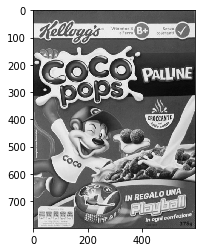

In [120]:
#plt.figure(figsize=(10,10))
plt.imshow(img_prod_gr, cmap='gray')

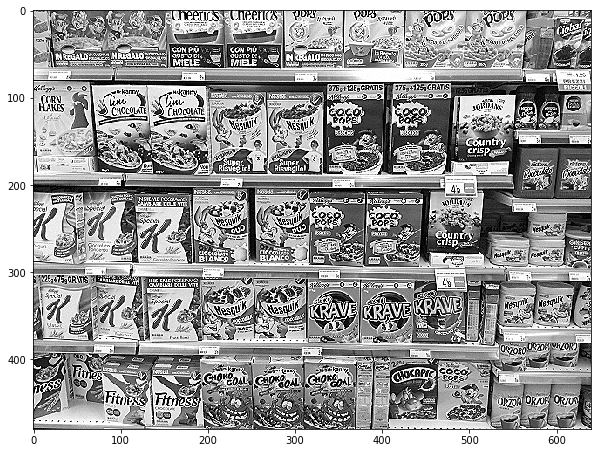

In [147]:
plt.figure(figsize=(10,10))
plt.imshow(img_scene_pre, cmap='gray')

In [122]:
# Detecting keypoints and computing the descriptors for each keypoints in the product image
sift = cv2.xfeatures2d.SIFT_create()
kp_p, des_p = sift.detectAndCompute(img_prod_gr, None)

# Compute the barycenter for the GHT
x = np.mean([kp.pt[0] for kp in kp_p])
y = np.mean([kp.pt[1] for kp in kp_p])
barycen_p = [x,y]

In [123]:
barycen_p

[321.8635759276036, 501.2949750660364]

In [146]:

sharpen_kernel = np.array([
            [0,-1,0],
            [-1,5,-1],
            [0,-1,0]])
img_scene_pre = cv2.filter2D(img_scene_gr,-1,sharpen_kernel)
img_scene_pre = np.abs(img_scene_pre)

# Detecting keypoints and computing the descriptors for each keypoints in the scene image
sift = cv2.xfeatures2d.SIFT_create()
kp_s, des_s = sift.detectAndCompute(img_scene_pre, None)

In [148]:
# Initializing the matching algorithm
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching the descriptors
matches = flann.knnMatch(des_p,des_s,k=2)

# Keeping only good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [149]:
len(good)

12

In [94]:
aa_quant_fact = 5
aa_matrix = np.zeros((img_scene_gr.shape[0]//aa_quant_fact, img_scene_gr.shape[1]//aa_quant_fact))


In [95]:
aa_matrix.shape

(213, 214)

In [150]:
# Online phase of the GHT algorithm
aa_quant_fact = 5
aa_matrix = np.zeros((img_scene_gr.shape[0]//aa_quant_fact, img_scene_gr.shape[1]//aa_quant_fact))
dict_matches = {}

for m in good:
    # Retrieve only good matches
    kp_p_good = kp_p[m.queryIdx]
    kp_s_good = kp_s[m.trainIdx]

    # Compute the vector that connects each keypoint to the barycenter
    vec = np.subtract(barycen_p, kp_p_good.pt)

    # Scale the vector 
    vec_scaled = np.multiply(vec, kp_s_good.size/kp_p_good.size)

    # Rotate the vector
    rot_angle = math.radians(kp_s_good.angle - kp_p_good.angle)
    rot_matrix = np.array(((np.cos(rot_angle), -np.sin(rot_angle)),(np.sin(rot_angle), np.cos(rot_angle))))
    vec_scaled_rot = rot_matrix.dot(vec_scaled)
    
    # Calculate barycenter
    bar_x = int(round(kp_s_good.pt[0] + vec_scaled_rot[0])//aa_quant_fact)
    bar_y = int(round(kp_s_good.pt[1] + vec_scaled_rot[1])//aa_quant_fact)
    
    bar = (bar_x, bar_y)
    if bar in dict_matches.keys():
        dict_matches[bar].append(m)
    else:
        dict_matches[bar] = [m]
                
    
    # Cast a vote
    if 0 <= bar[0] < aa_matrix.shape[1] and 0 <= bar[1] < aa_matrix.shape[0]:
        aa_matrix[bar[1], bar[0]] += 1

In [186]:
aaMatches

NameError: name 'aaMatches' is not defined

In [13]:
aa_matrix.shape

(123, 278)

In [15]:
np.max(aa_matrix)

3.0

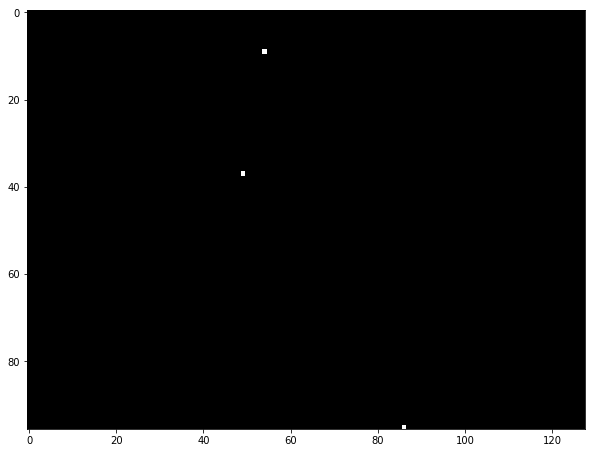

In [151]:
plt.figure(figsize=(10,10))
plt.imshow(aa_matrix, cmap='gray')

In [422]:
non_null = aa_matrix>0

In [152]:
non_null=np.concatenate((np.nonzero(aa_matrix)[1].reshape((-1,1)), np.nonzero(aa_matrix)[0].reshape((-1,1))), axis=1)

In [130]:
non_null[1]

array([47, 11])

In [42]:
np.array(non_null_2)

array([[132,  41],
       [ 96,  48],
       [ 97,  50],
       [ 98,  50],
       [ 99,  50],
       [ 99,  50],
       [100,  50],
       [234,  50],
       [235,  50],
       [ 99,  51],
       [102,  51],
       [ 86,  52],
       [ 98,  52],
       [ 99,  52],
       [ 99,  52],
       [ 99,  52],
       [100,  52],
       [101,  52],
       [102,  52],
       [102,  52],
       [103,  52],
       [107,  52],
       [165,  52],
       [233,  52],
       [233,  52],
       [234,  52],
       [ 99,  53],
       [163,  53],
       [163,  53],
       [166,  53],
       [167,  53],
       [168,  53],
       [230,  53],
       [231,  53],
       [233,  53],
       [233,  53],
       [234,  53],
       [166,  54],
       [167,  54],
       [167,  54],
       [168,  54],
       [230,  54],
       [240,  54],
       [167,  55],
       [ 97,  56],
       [174,  56],
       [166,  58],
       [236,  58],
       [ 99,  59],
       [ 96,  60],
       [ 98,  61],
       [ 99,  61],
       [157,

In [153]:
non_null_2 = []
for i in range(non_null.shape[0]):
    for j in range(int(aa_matrix[non_null[i,1],non_null[i,0]])):
        non_null_2.append(non_null[i].tolist())
non_null_2 = np.array(non_null_2)

In [154]:
non_null.shape, non_null_2.shape

((3, 2), (3, 2))

In [155]:
from sklearn.cluster import DBSCAN
y = DBSCAN(eps=10, min_samples=1).fit_predict(non_null_2)

In [156]:
y

array([0, 1, 2])

In [157]:
cluster_labels_all = np.unique(y)
cluster_labels = cluster_labels_all[cluster_labels_all != -1]
n_clusters = len(cluster_labels)

In [158]:
cluster_labels_all = np.unique(y)
cluster_labels = cluster_labels_all[cluster_labels_all != -1]
n_clusters = len(cluster_labels)
cl = []
for i in cluster_labels:
    cl.append(non_null_2[y==i].tolist())

In [159]:
cl

[[[54, 9]], [[49, 37]], [[86, 95]]]

In [161]:
for instance in cl:
    instanceMatches = []
    for pt in instance:
        instanceMatches += dict_matches[tuple(pt)]
    print(len(instanceMatches))
    if len(instanceMatches) >= 1:
        prova = instanceMatches

1
1
1


In [162]:
prova

[<DMatch 0x7f8872876850>]

In [67]:
maxDist = 15
clusters = []

for y in range(aa_matrix.shape[0]):
    for x in range(aa_matrix.shape[1]):
        if aa_matrix[y,x] > 0:
            poss_cl = []
            for cl_id, cl in enumerate(clusters):
                for pt in cl:
                    dist = math.sqrt((x-pt[0])**2 + (y-pt[1])**2)
                    if dist <= maxDist:
                        poss_cl.append(cl_id)
                        break

            if len(poss_cl) == 0:
                # Create a new cluster
                clusters.append([(x,y)]) 
            else:
                # Combine clusters
                for cl in poss_cl[1:][::-1]:
                    clusters[poss_cl[0]] += clusters[cl]
                    del clusters[cl]

                clusters[poss_cl[0]].append((x,y))


In [202]:
len(clusters)

2

In [203]:
clusters

[[(171, 42),
  (172, 45),
  (171, 47),
  (172, 47),
  (175, 47),
  (165, 48),
  (169, 48),
  (170, 48),
  (171, 48),
  (173, 48),
  (173, 50),
  (175, 50),
  (167, 52),
  (174, 53),
  (173, 56)],
 [(50, 48)]]

In [205]:
for instance in clusters:
    instanceMatches = []
    for pt in instance:
        instanceMatches += dict_matches[pt]
    print(len(instanceMatches))
    if len(instanceMatches) > 10:
        prova = instanceMatches

15
1


In [206]:
prova

[<DMatch 0x7fc6e189fa10>,
 <DMatch 0x7fc6e1891970>,
 <DMatch 0x7fc6e189fab0>,
 <DMatch 0x7fc6e18a3e30>,
 <DMatch 0x7fc6e18a39b0>,
 <DMatch 0x7fc6e1891b30>,
 <DMatch 0x7fc6e189fad0>,
 <DMatch 0x7fc6e189f410>,
 <DMatch 0x7fc6e1891e90>,
 <DMatch 0x7fc6e18a3890>,
 <DMatch 0x7fc6e18a32d0>,
 <DMatch 0x7fc6e1891030>,
 <DMatch 0x7fc6e189fcf0>,
 <DMatch 0x7fc6e18a3690>,
 <DMatch 0x7fc6e18a3190>]

In [143]:
len(instanceMatches)

1

In [163]:
src_pts = np.float32([ kp_p[m.queryIdx].pt for m in prova ]).reshape(-1,1,2)
dst_pts = np.float32([ kp_s[m.trainIdx].pt for m in prova ]).reshape(-1,1,2)

# Calculating homography based on correspondences
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Matches mask for visualization of only matches used by RANSAC
matchesMask = mask.ravel().tolist()

# Apply homography to project corners of the query image into the image
h,w = img_prod_gr.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)

# Calculate the bounding box
x, y, w, h = cv2.boundingRect(dst)

# Drawing bounding box
final_img = img_scene.copy()
final_img = cv2.polylines(final_img,np.int32([dst]),True,(0,255,0), 3, cv2.LINE_AA)
final_img_rgb = cv2.cvtColor(final_img,cv2.COLOR_BGR2RGB)
plt.imshow(final_img_rgb)
plt.show()

error: OpenCV(3.4.2) /io/opencv/modules/core/src/matmul.cpp:2268: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'
